In [2]:
import numpy as np
import pandas as pd

from vpop_calibration import *

from IPython.display import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Define the ode model
def equations(t, y, k_12, k_21, k_el, t_clear):
    ydot = [  # y[0] is A1, y[1] is A2
        k_21 * y[1] - k_12 * y[0] - (k_el * (t >= t_clear)) * y[0],
        k_12 * y[0] - k_21 * y[1],
    ]
    return ydot


variable_names = ["A0", "A1"]
parameter_names = ["k_12", "k_21", "k_el", "t_clear"]

pk_two_compartments_model = OdeModel(equations, variable_names, parameter_names)

In [4]:
nb_timesteps = 15
tmax = 24.0
initial_conditions = np.array([10.0, 0.0])
time_steps = np.linspace(0.0, tmax, nb_timesteps)

log_nb_patients = 8
nb_patients = 2**log_nb_patients
print(nb_patients)
param_ranges = {
    "k_12": {"low": 0.02, "high": 0.07, "log": False},
    "k_21": {"low": 0.1, "high": 0.3, "log": False},
}

protocol_design = pd.DataFrame({"protocol_arm": ["A", "B"], "k_el": [0.1, 0.5]})
descriptors = [*param_ranges.keys(), "t_clear", "time"]
n_tasks = protocol_design.shape[0] * len(variable_names)
vpop = generate_vpop_from_ranges(log_nb_patients, param_ranges)
rng = np.random.default_rng()
vpop["t_clear"] = rng.integers(0, 24, nb_patients)
protocol_arms = ["A", "B"]
vpop = vpop.merge(
    pd.DataFrame(data=variable_names, columns=["output_name"]), how="cross"
)
vpop = vpop.merge(
    pd.DataFrame(data=protocol_arms, columns=["protocol_arm"]), how="cross"
)
display(vpop)

256


,id,k_12,k_21,t_clear,output_name,protocol_arm
0,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A0,A
1,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A0,B
2,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A1,A
3,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A1,B
4,cf3cb2f7-62cf-4bd0-8307-a5cc9aa332d4,0.054862,0.178418,8,A0,A
...,...,...,...,...,...,...
1019,defbc663-7049-4e3d-9f8b-6274edf7e85c,0.055061,0.279487,8,A1,B
1020,97582384-1dc1-4b29-9741-589da366b302,0.029825,0.131789,0,A0,A
1021,97582384-1dc1-4b29-9741-589da366b302,0.029825,0.131789,0,A0,B
1022,97582384-1dc1-4b29-9741-589da366b302,0.029825,0.131789,0,A1,A


In [5]:
dataset = pk_two_compartments_model.run_trial(
    vpop, initial_conditions, protocol_design, time_steps
)
dataset = dataset.rename(columns={"predicted_value": "value"})
display(dataset)

,id,k_12,k_21,t_clear,output_name,protocol_arm,time,A0_0,A1_0,k_el,value
0,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A0,A,0.000000,10.0,0.0,0.1,10.000000
1,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A0,A,1.714286,10.0,0.0,0.1,9.584529
2,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A0,A,3.428571,10.0,0.0,0.1,9.319595
3,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A0,A,5.142857,10.0,0.0,0.1,9.150659
4,8ff891e6-4cfa-4a2e-82e5-8e21e6035617,0.030096,0.232370,13,A0,A,6.857143,10.0,0.0,0.1,9.042933
...,...,...,...,...,...,...,...,...,...,...,...
15355,97582384-1dc1-4b29-9741-589da366b302,0.029825,0.131789,0,A1,B,17.142857,10.0,0.0,0.5,0.087978
15356,97582384-1dc1-4b29-9741-589da366b302,0.029825,0.131789,0,A1,B,18.857143,10.0,0.0,0.5,0.071385
15357,97582384-1dc1-4b29-9741-589da366b302,0.029825,0.131789,0,A1,B,20.571429,10.0,0.0,0.5,0.057910
15358,97582384-1dc1-4b29-9741-589da366b302,0.029825,0.131789,0,A1,B,22.285714,10.0,0.0,0.5,0.046974


In [6]:
def join_if_two(tup):
    if tup[0] == "":
        return tup[1]
    elif tup[1] == "":
        return tup[0]
    else:
        return "_".join(tup)


reshaped_df = dataset.pivot(
    index=["id"] + descriptors,
    columns=["output_name", "protocol_arm"],
    values="value",
).reset_index()
reshaped_df.columns = list(map(join_if_two, reshaped_df.columns))
display(reshaped_df)

,id,k_12,k_21,t_clear,time,A0_A,A0_B,A1_A,A1_B
0,00ecae8b-e874-4538-bf15-a9b4e8bc9679,0.064715,0.111454,18,0.000000,10.000000,10.000000,0.000000,0.000000
1,00ecae8b-e874-4538-bf15-a9b4e8bc9679,0.064715,0.111454,18,1.714286,9.042462,9.042462,0.957538,0.957538
2,00ecae8b-e874-4538-bf15-a9b4e8bc9679,0.064715,0.111454,18,3.428571,8.334517,8.334517,1.665483,1.665483
3,00ecae8b-e874-4538-bf15-a9b4e8bc9679,0.064715,0.111454,18,5.142857,7.811115,7.811115,2.188885,2.188885
4,00ecae8b-e874-4538-bf15-a9b4e8bc9679,0.064715,0.111454,18,6.857143,7.424139,7.424139,2.575861,2.575861
...,...,...,...,...,...,...,...,...,...
3835,fb5e5a6d-6e44-4e3f-8e38-6d3ddf94c3c0,0.042290,0.206285,17,17.142857,8.204983,7.750607,1.676958,1.675578
3836,fb5e5a6d-6e44-4e3f-8e38-6d3ddf94c3c0,0.042290,0.206285,17,18.857143,6.950588,3.424807,1.636461,1.490248
3837,fb5e5a6d-6e44-4e3f-8e38-6d3ddf94c3c0,0.042290,0.206285,17,20.571429,5.944863,1.655473,1.539872,1.190632
3838,fb5e5a6d-6e44-4e3f-8e38-6d3ddf94c3c0,0.042290,0.206285,17,22.285714,5.121611,0.889359,1.416812,0.909256


In [7]:
# initiate our GP class
myGP = GP(
    dataset,
    descriptors,
    var_strat="IMV",  # either IMV (Independent Multitask Variational) or LMCV (Linear Model of Coregionalization Variational)
    kernel="Deep-RBF",  # Either RBF or SMK
    data_already_normalized=False,  # default
    nb_inducing_points=100,
    mll="ELBO",  # default, otherwise PLL
    nb_training_iter=200,
    training_proportion=0.7,
    learning_rate=0.1,
    lr_decay=0.99,
    jitter=1e-6,
    log_inputs=[],
    log_outputs=["A0", "A1"],
)

Successfully loaded a training data set with 256 patients. The following outputs are available:
['A0', 'A1']
 and the following protocol arms:
['A', 'B']


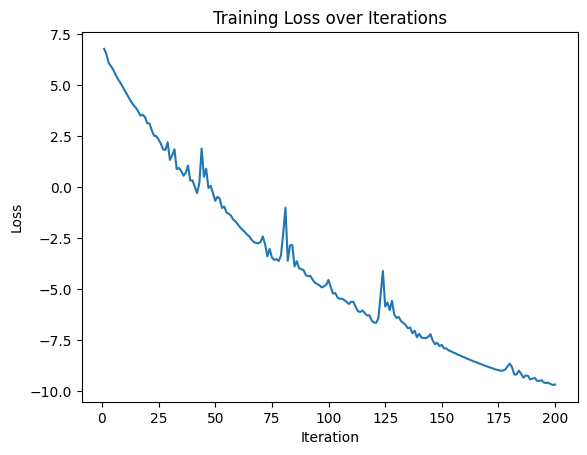

In [12]:
myGP.plot_loss()

In [8]:
myGP.train()

100%|██████████| 200/200 [00:49<00:00,  4.04it/s, loss=-9.66] 


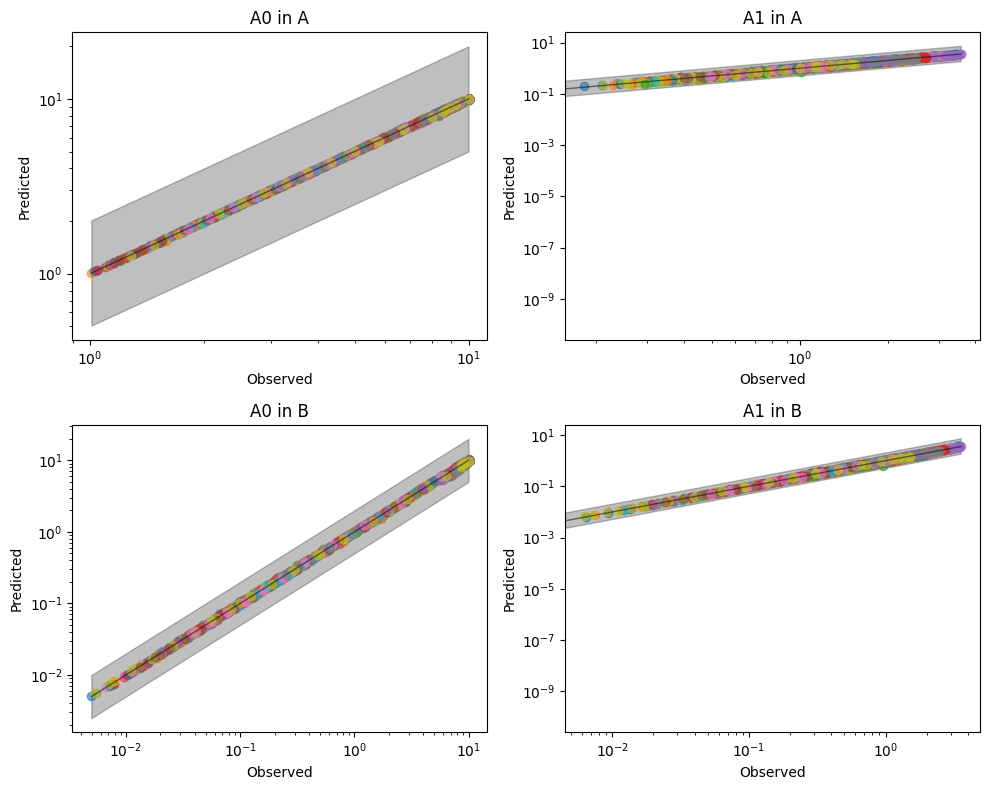

In [11]:
myGP.plot_obs_vs_predicted("training")

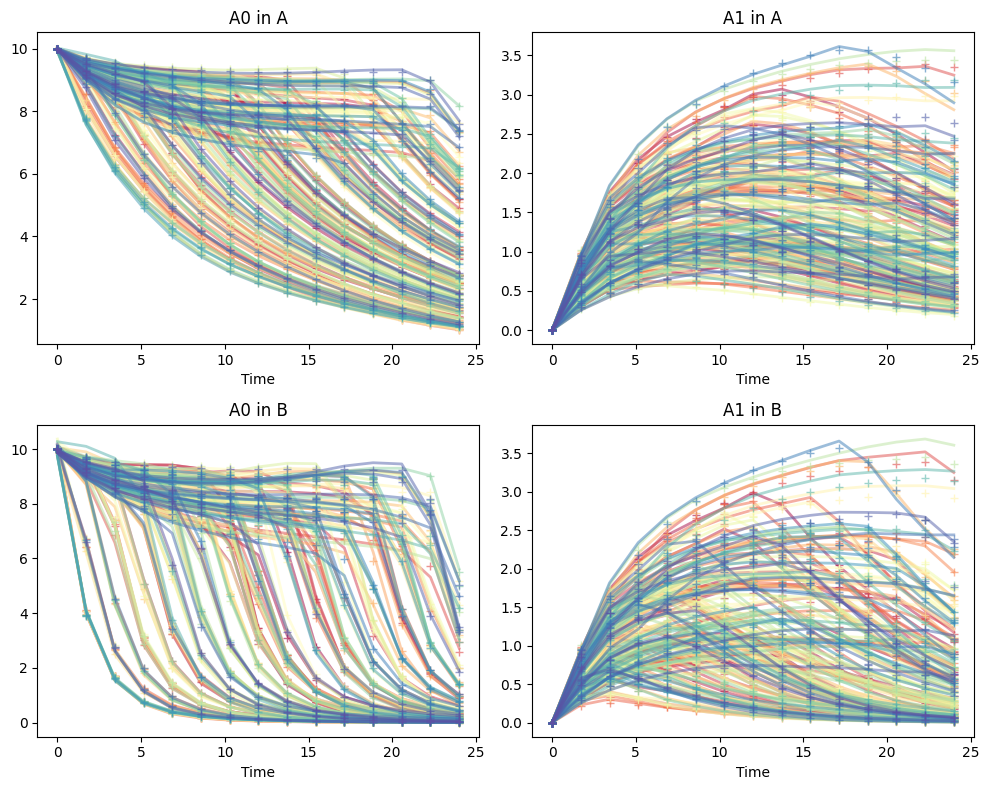

In [10]:
myGP.plot_all_solutions("training")